To Queue or Not to Queue
=====================

In this notebook we look at the relative performance of a single queue vs multiple queues
using the [Simpy](https://simpy.readthedocs.io/en/latest/) framework as well as exploring various
common load balancing algorithms and their performance in M/G/k systems.

In [1]:
import random

import numpy as np
import simpy


class RequestSimulator(object):
    """ Simulates a M/G/k process common in request processing (computing)

    :param worker_desc: A tuple of (count, capacity) to construct workers with
    :param local_balancer: A function which takes the current request number and the
                           list of workers and returns the index of the worker to
                           send the next request to
    :param latency_fn: A parameterless function which returns the number of milliseconds
                       a request took to process
    :param number_of_requests: The number of requests to run through the simulator
    :param request_per_s: The rate of requests per second.
    """
    def __init__(
            self, worker_desc, load_balancer, latency_fn,
            number_of_requests, request_per_s):
        self.worker_desc = worker_desc
        self.load_balancer = load_balancer
        self.latency_fn = latency_fn
        self.number_of_requests = int(number_of_requests)
        self.request_interval_ms = 1. / (request_per_s / 1000.)
        self.data = []

    def simulate(self):
        # Setup and start the simulation
        random.seed(1)
        np.random.seed(1)

        self.env = simpy.Environment()
        count, cap = self.worker_desc
        self.workers = [
            simpy.Resource(self.env, capacity=cap) for i in range(count)
        ]
        self.env.process(self.generate_requests())
        self.env.run()

    def generate_requests(self):
        for i in range(self.number_of_requests):
            idx = self.load_balancer(i, self.workers)
            worker = self.workers[idx]
            response = self.process_request(
                'Request%02d' % i, worker,
            )
            self.env.process(response)
            # Exponential inter-arrival times == Poisson
            arrival_interval = random.expovariate(
                1.0 / self.request_interval_ms
            )
            yield self.env.timeout(arrival_interval)

    def process_request(self, name, worker):
        """ Request arrives, possibly queues, and then processes"""
        t_arrive = self.env.now

        with worker.request() as req:
            yield req
                        
            t_start = self.env.now
            t_queued = t_start - t_arrive

            # Let the operation take w.e. amount of time the latency
            # function tells us to
            yield self.env.timeout(self.latency_fn())

            t_done = self.env.now
            t_processing = t_done - t_start
            t_total_response = t_done - t_arrive

            datum = (t_queued, t_processing, t_total_response)
            self.data.append(datum)


def run_simulation(
        worker_desc, load_balancer, num_requests, request_per_s, latency_fn):
    simulator = RequestSimulator(
        worker_desc, load_balancer, latency_fn,
        num_requests, request_per_s
    )
    simulator.simulate()
    return simulator.data

In [2]:
def queue_size(resource):
    return resource.count + len(resource.queue)


def random_lb(request_num, workers):
    return random.randint(0, len(workers) - 1)


def rr_lb(request_num, workers):
    return request_num % len(workers)


def choice_two_lb(request_num, workers):
    r1 = random_lb(request_num, workers)
    r2 = random_lb(request_num, workers)
    if queue_size(workers[r1]) < queue_size(workers[r2]):
        return r1
    return r2


def choice_two_adjacent_lb(request_num, workers):
    r1 = random_lb(request_num, workers)
    if r1 + 2 >= len(workers):
        r2 = r1 - 1
        r3 = r1 - 2
    else:
        r2 = r1 + 1
        r3 = r1 + 2

    iq = [(queue_size(workers[i]), i) for i in (r1, r2, r3)]
    return (sorted(iq)[0][1])


def shortest_queue_lb(request_num, workers):
    idx = 0
    for i in range(len(workers)):
        if queue_size(workers[i]) < queue_size(workers[idx]):
            idx = i
    return idx

lb_algos = {
    'choice_two': choice_two_lb,
    'random': random_lb,
    'roundrobin': rr_lb,
    'JSQ': shortest_queue_lb,
}

def pareto(mean, shape):
    # mean = scale * shape / (shape - 1)
    # solve for scale given mean and shape (aka skew) 
    scale = mean - mean / shape 
    return lambda: ((np.random.pareto(shape) + 1) * scale)


def expon(mean):
    return lambda: random.expovariate(1.0 / mean)
  

# Simulate the various choices
NUM_REQUESTS = 50000
QPS = 20000
AVG_RESPONSE_MS = 0.4
SERVERS = 10

Simulation of Single vs Multiple Queues
================================

Here we explore the effects of having N queues that handle 1/N the load (aka "Frequency Division Multiplexing",
aka `FDM`) vs a single queue distributing out to N servers (aka M/M/k queue aka `MMk`). We confirm the theoretical results that can be obtained using the closed form solutions for `E[T]_MMk` and `E[T]_FDM` via
a simulation.

In particular M/M/k queues have a closed form solution for the mean response time given the probability of queueing (and we know if requests queued)
```
E[T]_MMk = (1 / λ) * Pq * ρ / (1-ρ) + 1 / μ
Where
λ  = the arrival rate (hertz)
Pq = the probability of a request queueing
ρ  = the system load aka λ / (k * μ)
μ  = the average response time (hertz)
```

Frequency division multiplexing (multiple queues) also has a closed form solution:
```
E[T]_FDM = (k / (k * μ - λ))
```

In [3]:
multiple_queues_latency = []
for i in range(SERVERS):
    multiple_queues_latency.extend([
        i[2] for i in run_simulation((1, 1), rr_lb, NUM_REQUESTS/SERVERS, QPS/SERVERS, expon(AVG_RESPONSE_MS))
    ])
    
single_queue = [
    i for i in run_simulation((1, SERVERS), rr_lb, NUM_REQUESTS, QPS, expon(AVG_RESPONSE_MS))
]
single_queue_latency = [i[2] for i in single_queue]


join_shorted_queue_latency = [
    i[2] for i in run_simulation((SERVERS, 1), shortest_queue_lb, NUM_REQUESTS, QPS, expon(AVG_RESPONSE_MS))
]

two_adjacent_latency = [
    i[2] for i in run_simulation((SERVERS, 1), choice_two_adjacent_lb, NUM_REQUESTS, QPS, expon(AVG_RESPONSE_MS))
]

Pq = sum([i[0] > 0 for i in single_queue]) / float(NUM_REQUESTS)

# MMk have a closed for mean given the probability of queueing (and we know if requests queued)
# E[T]_MMk = (1 / λ) * Pq * ρ / (1-ρ) + 1 / μ
# Where
# λ  = the arrival rate (hertz)
# Pq = the probability of a request queueing
# ρ  = the system load aka λ / (k * μ)
# μ  = the average response time (hertz)
mu_MMk = (1.0 / AVG_RESPONSE_MS) * 1000
lambda_MMk = QPS
rho_MMk = lambda_MMk / (SERVERS * mu_MMk)
expected_MMk_mean_s = (1 / (lambda_MMk)) * Pq * (rho_MMk / (1-rho_MMk)) + 1 / mu_MMk
expected_MMk_mean_ms = expected_MMk_mean_s * 1000.0

# Frequency-division multiplexing also has a closed form for mean
# E[T]_FDM = (k / (k * μ - λ))

expected_FDM_mean_ms = (SERVERS / (SERVERS * mu_MMk - lambda_MMk)) * 1000.0

print("Theory Results")
print("--------------")
print("Pq       = {0:4.2f}".format(Pq))
print("E[T]_MMk = {0:4.2f}".format(expected_MMk_mean_ms))
print("E[T]_FDM = {0:4.2f}".format(expected_FDM_mean_ms))

# And now the simulation
queueing_options = {
    'FDM': multiple_queues_latency,
    'MMk': single_queue_latency,
    'JSQ': join_shorted_queue_latency,
    'C2A': two_adjacent_latency
}

print()
print("Simulation results")
print("------------------")
hdr = "{0:10} | {1:>7} | {2:>7} | {3:>7} | {4:>7} | {5:>7} | {6:>7} ".format(
"Strategy", "mean", "var", "p50", "p95", "p99", "p99.9")
print(hdr)
for opt in sorted(queueing_options.keys()):
    mean = np.mean(queueing_options[opt])
    var = np.var(queueing_options[opt])
    percentiles = np.percentile(queueing_options[opt], [50, 95, 99, 99.9])
    print ("{0:10} | {1:7.2f} | {2:7.2f} | {3:7.2f} | {4:7.2f} | {5:>7.2f} | {6:7.2f} |".format(
        opt, mean, var, percentiles[0], percentiles[1], percentiles[2],
        percentiles[3]
    ))

Theory Results
--------------
Pq       = 0.40
E[T]_MMk = 0.48
E[T]_FDM = 2.00

Simulation results
------------------
Strategy   |    mean |     var |     p50 |     p95 |     p99 |   p99.9 
C2A        |    0.92 |    0.67 |    0.70 |    2.58 |    3.64 |    4.93 |
FDM        |    1.85 |    2.89 |    1.38 |    5.12 |    7.86 |   10.63 |
JSQ        |    0.56 |    0.28 |    0.40 |    1.62 |    2.41 |    3.48 |
MMk        |    0.48 |    0.19 |    0.36 |    1.33 |    1.99 |    2.92 |


4


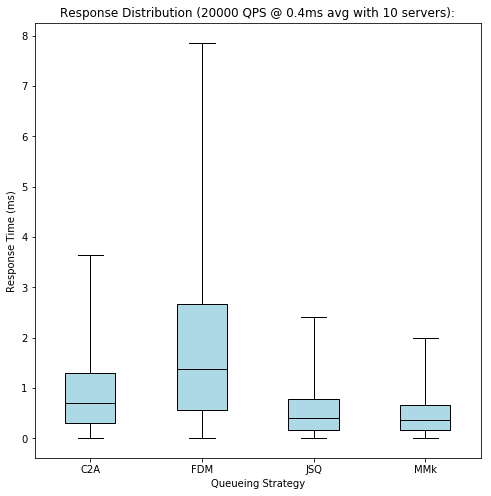

In [7]:
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


def color_bplot(bp, edge_color, fill_color):
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for box in bp['boxes']:
        box.set_facecolor(fill_color)  

fig1, ax = plt.subplots(figsize=(8,8))

diamond = dict(markerfacecolor='r', marker='D')

opts = sorted(queueing_options.keys())
data = [queueing_options[i] for i in opts]
print(len(queueing_options))

bplot1 = ax.boxplot(data,whis=[1,99],showfliers=False,flierprops=diamond, labels=opts, patch_artist=True)
color_bplot(bplot1, 'black', 'lightblue')

plt.title('Response Distribution ({0} QPS @ {1}ms avg with {2} servers):'.format(
    QPS, AVG_RESPONSE_MS, SERVERS)
)
plt.xlabel('Queueing Strategy')
plt.ylabel('Response Time (ms)')
plt.show()

Simulation of M/G/k queues
======================

Now we look at M/G/k queues over multiple different load balancing choices.

We explore:
* Join Shorted Queue (JSK): The request is dispatched to the shortest queue
* M/G/k (MGk): A single queue is maintained and workers take requests as they are free
* Choice of two (choice_two): Two random workers are chosen, and then the request goes to the shorter queue
* Random (random): A random queue is chosen
* Round-robin (roundrobin): The requests are dispatched to one queue after the other


In [5]:
lbs = {
    k : [i[2] for i in run_simulation((SERVERS, 1), v, NUM_REQUESTS, QPS, pareto(AVG_RESPONSE_MS, 2))]
    for (k, v) in lb_algos.items()
}
lbs['MGk'] = [
    i[2] for i in run_simulation((1, SERVERS), rr_lb, NUM_REQUESTS, QPS, pareto(AVG_RESPONSE_MS, 2))]

types = sorted(lbs.keys())

hdr = "{0:10} | {1:>7} | {2:>7} | {3:>7} | {4:>7} | {5:>7} | {6:>7} ".format(
"Strategy", "mean", "var", "p50", "p95", "p99", "p99.9")
#hdr = "Strategy   |  mean   |   var   |   p50   | p95 | p99 | p99.9 | max"
print(hdr)
for lb in types:
    mean = np.mean(lbs[lb])
    var = np.var(lbs[lb])
    percentiles = np.percentile(lbs[lb], [50, 95, 99, 99.9])
    print ("{0:10} | {1:7.1f} | {2:7.1f} | {3:7.1f} | {4:7.1f} | {5:>7.1f} | {6:7.1f} |".format(
        lb, mean, var, percentiles[0], percentiles[1], percentiles[2],
        percentiles[3]
    ))

Strategy   |    mean |     var |     p50 |     p95 |     p99 |   p99.9 
JSQ        |     0.5 |     0.6 |     0.4 |     1.3 |     2.7 |     8.6 |
MGk        |     0.5 |     0.3 |     0.3 |     1.1 |     2.1 |     6.1 |
choice_two |     0.8 |     1.7 |     0.5 |     2.1 |     4.6 |    13.5 |
random     |     2.7 |    34.2 |     1.1 |     9.5 |    32.8 |    64.5 |
roundrobin |     1.8 |    19.5 |     0.5 |     6.9 |    25.2 |    56.1 |


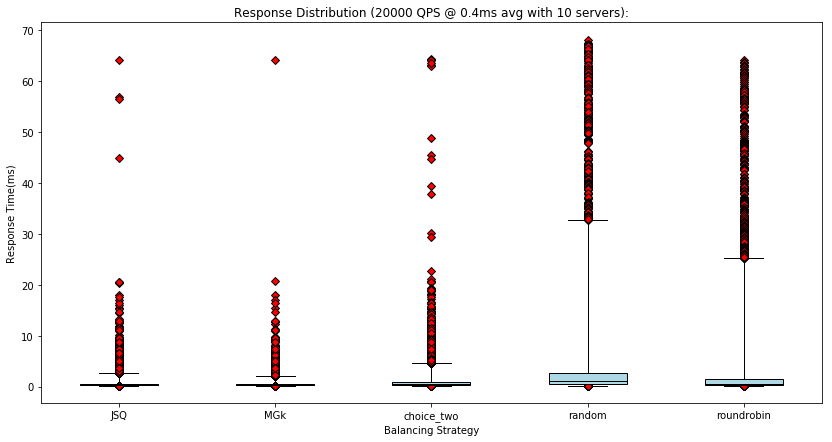

In [8]:
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


def color_bplot(bp, edge_color, fill_color):
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for box in bp['boxes']:
        box.set_facecolor(fill_color)  

fig1, ax = plt.subplots(figsize=(14,7))

diamond = dict(markerfacecolor='r', marker='D')

data = [lbs[i] for i in types]
bplot1 = ax.boxplot(data,whis=[1,99],showfliers=True,flierprops=diamond, labels=types, patch_artist=True)
color_bplot(bplot1, 'black', 'lightblue')

plt.title('Response Distribution ({0} QPS @ {1}ms avg with {2} servers):'.format(
    QPS, AVG_RESPONSE_MS, SERVERS)
)
plt.xlabel('Balancing Strategy')
plt.ylabel('Response Time(ms)')
plt.show()